In [42]:
import pandas as pd
import numpy as np
# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# from ydata_profiling import ProfileReport

pd.set_option('display.max_rows', None)

In [3]:
df_raw = pd.read_csv("../data/petfinder-adoption-prediction/train/train.csv")
df_raw.columns = df_raw.columns.str.lower()

In [4]:
df_raw.head().T

,0,1,2,3,4
type,2,2,1,1,1
name,Nibble,No Name Yet,Brisco,Miko,Hunter
age,3,1,1,4,1
breed1,299,265,307,307,307
breed2,0,0,0,0,0
gender,1,1,1,2,1
color1,1,1,2,1,1
color2,7,2,7,2,0
color3,0,0,0,0,0
maturitysize,1,2,2,2,2


In [5]:
# #eda_report = ProfileReport(df_raw, title="Eda report")
# eda_report.to_file("eda_report.html")

In [6]:
df_raw.columns

Index(['type', 'name', 'age', 'breed1', 'breed2', 'gender', 'color1', 'color2',
       'color3', 'maturitysize', 'furlength', 'vaccinated', 'dewormed',
       'sterilized', 'health', 'quantity', 'fee', 'state', 'rescuerid',
       'videoamt', 'description', 'petid', 'photoamt', 'adoptionspeed'],
      dtype='object')

In [7]:
df_dropped = df_raw.drop(["state","petid","rescuerid","name"],axis=1)
df_dropped.columns

Index(['type', 'age', 'breed1', 'breed2', 'gender', 'color1', 'color2',
       'color3', 'maturitysize', 'furlength', 'vaccinated', 'dewormed',
       'sterilized', 'health', 'quantity', 'fee', 'videoamt', 'description',
       'photoamt', 'adoptionspeed'],
      dtype='object')

In [8]:
df_dropped.adoptionspeed.value_counts(normalize=True)

adoptionspeed
4    0.279931
2    0.269259
3    0.217368
1    0.206096
0    0.027346
Name: proportion, dtype: float64

In [9]:
pd.crosstab([df_dropped["color1"],df_dropped["color2"],df_dropped["type"]],df_dropped["adoptionspeed"],normalize="index")

adoptionspeed              0         1         2         3         4
color1 color2 type                                                  
1      0      1     0.012270  0.154908  0.266871  0.222393  0.343558
              2     0.014286  0.231429  0.254286  0.191429  0.308571
       2      1     0.018836  0.168664  0.291524  0.250428  0.270548
              2     0.036847  0.213920  0.269191  0.180143  0.299898
       3      1     0.030303  0.262626  0.181818  0.272727  0.252525
              2     0.031746  0.230159  0.289683  0.214286  0.234127
       4      1     0.000000  0.212121  0.303030  0.191919  0.292929
              2     0.017722  0.174684  0.275949  0.205063  0.326582
       5      1     0.021739  0.231884  0.275362  0.231884  0.239130
              2     0.016393  0.254098  0.254098  0.204918  0.270492
       6      1     0.046875  0.203125  0.281250  0.234375  0.234375
              2     0.035211  0.286972  0.255282  0.184859  0.237676
       7      1     0.010791  0.196043  0.258993  0.255396  0.278777
              2     0.034188  0.233211  0.272283  0.195360  0.264957
2      0      1     0.024314  0.159216  0.241569  0.240000  0.334902
              2     0.054054  0.302703  0.248649  0.172973  0.221622
       3      1     0.015625  0.177083  0.213542  0.208333  0.385417
              2     0.011976  0.245509  0.263473  0.215569  0.263473
       4      1     0.024390  0.085366  0.256098  0.207317  0.426829
              2     0.042553  0.191489  0.283688  0.212766  0.269504
       5      1     0.027701  0.157895  0.288089  0.221607  0.304709
              2     0.084746  0.271186  0.275424  0.177966  0.190678
       6      1     0.048780  0.121951  0.341463  0.146341  0.341463
              2     0.042553  0.184397  0.241135  0.226950  0.304965
       7      1     0.018362  0.162429  0.261299  0.269774  0.288136
              2     0.063348  0.244344  0.244344  0.190045  0.257919
3      0      1     0.046875  0.182292  0.270833  0.208333  0.291667
              2     0.033898  0.265537  0.316384  0.158192  0.225989
       4      1     0.032258  0.161290  0.225806  0.161290  0.419355
              2     0.016393  0.270492  0.286885  0.180328  0.245902
       5      1     0.011905  0.107143  0.273810  0.297619  0.309524
              2     0.042857  0.242857  0.342857  0.142857  0.228571
       6      1     0.250000  0.500000  0.250000  0.000000  0.000000
              2     0.015385  0.169231  0.338462  0.246154  0.230769
       7      1     0.064516  0.258065  0.354839  0.161290  0.161290
              2     0.017544  0.257310  0.315789  0.192982  0.216374
4      0      1     0.000000  0.171429  0.114286  0.257143  0.457143
              2     0.035398  0.265487  0.221239  0.194690  0.283186
       5      1     0.000000  0.200000  0.222222  0.266667  0.311111
              2     0.055556  0.250000  0.291667  0.194444  0.208333
       6      2     0.046154  0.138462  0.230769  0.200000  0.384615
       7      1     0.000000  0.058824  0.235294  0.235294  0.470588
              2     0.008511  0.255319  0.246809  0.246809  0.242553
5      0      1     0.028424  0.222222  0.258398  0.232558  0.258398
              2     0.041667  0.322917  0.250000  0.125000  0.260417
       6      1     0.066667  0.333333  0.200000  0.066667  0.333333
              2     0.060000  0.260000  0.340000  0.170000  0.170000
       7      1     0.039326  0.219101  0.258427  0.230337  0.252809
              2     0.046296  0.305556  0.287037  0.222222  0.138889
6      0      1     0.042553  0.191489  0.276596  0.106383  0.382979
              2     0.034615  0.203846  0.288462  0.196154  0.276923
       7      1     0.000000  0.250000  0.333333  0.208333  0.208333
              2     0.054711  0.249240  0.276596  0.203647  0.215805
7      0      1     0.019284  0.234160  0.247934  0.231405  0.267218
              2     0.019737  0.299342  0.302632  0.134868  0.243421

In [10]:
for column_name in df_dropped.columns:
    print(pd.crosstab(df_dropped[column_name], df_dropped["adoptionspeed"],normalize="index"))
    print("____________")

adoptionspeed         0         1         2         3         4
type                                                           
1              0.020905  0.176463  0.266109  0.239670  0.296852
2              0.034980  0.241218  0.272992  0.190934  0.259875
____________
adoptionspeed         0         1         2         3         4
age                                                            
0              0.055866  0.279330  0.245810  0.217877  0.201117
1              0.023438  0.279080  0.327257  0.221788  0.148438
2              0.032829  0.246931  0.319726  0.223523  0.176991
3              0.022380  0.207528  0.298067  0.232960  0.239064
4              0.021641  0.190261  0.238954  0.234445  0.314698
..                  ...       ...       ...       ...       ...
168            0.000000  0.000000  0.000000  1.000000  0.000000
180            0.000000  0.000000  0.000000  0.500000  0.500000
212            0.000000  0.000000  0.000000  0.666667  0.333333
238            0.000000  0.

<Axes: xlabel='quantity', ylabel='adoptionspeed'>

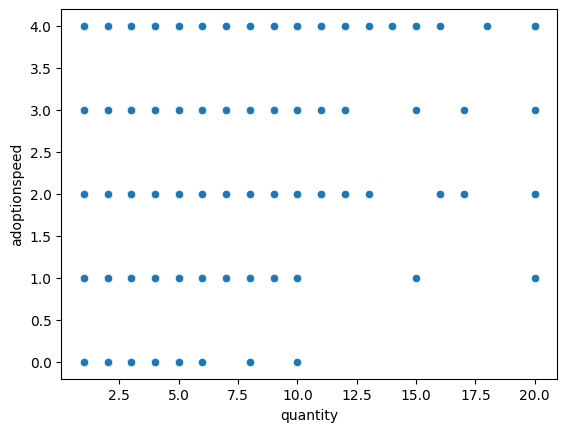

In [11]:
sns.scatterplot(data=df_dropped, x='quantity', y='adoptionspeed')

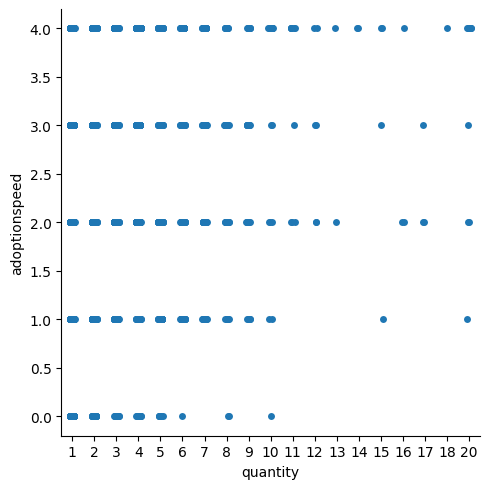

In [12]:
sns.catplot(data=df_dropped, x='quantity', y='adoptionspeed', jitter=True)

In [13]:
pd.crosstab(df_dropped.quantity, df_dropped.adoptionspeed)#, normalize="index")

adoptionspeed,0,1,2,3,4
quantity,,,,,
1,331,2439,3163,2552,3080
2,35,290,362,307,428
3,20,158,181,148,219
4,13,106,129,97,186
5,7,42,90,65,129
6,1,29,51,38,66
7,0,11,22,21,30
8,2,7,15,12,16
9,0,4,9,11,9


In [14]:
df_dropped.info()
# only missing values in description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   type           14993 non-null  int64  
 1   age            14993 non-null  int64  
 2   breed1         14993 non-null  int64  
 3   breed2         14993 non-null  int64  
 4   gender         14993 non-null  int64  
 5   color1         14993 non-null  int64  
 6   color2         14993 non-null  int64  
 7   color3         14993 non-null  int64  
 8   maturitysize   14993 non-null  int64  
 9   furlength      14993 non-null  int64  
 10  vaccinated     14993 non-null  int64  
 11  dewormed       14993 non-null  int64  
 12  sterilized     14993 non-null  int64  
 13  health         14993 non-null  int64  
 14  quantity       14993 non-null  int64  
 15  fee            14993 non-null  int64  
 16  videoamt       14993 non-null  int64  
 17  description    14980 non-null  object 
 18  photoa

In [15]:
df_color_breed = df_dropped[["color1", "color2", "color3", "breed1", "breed2", "type"]]

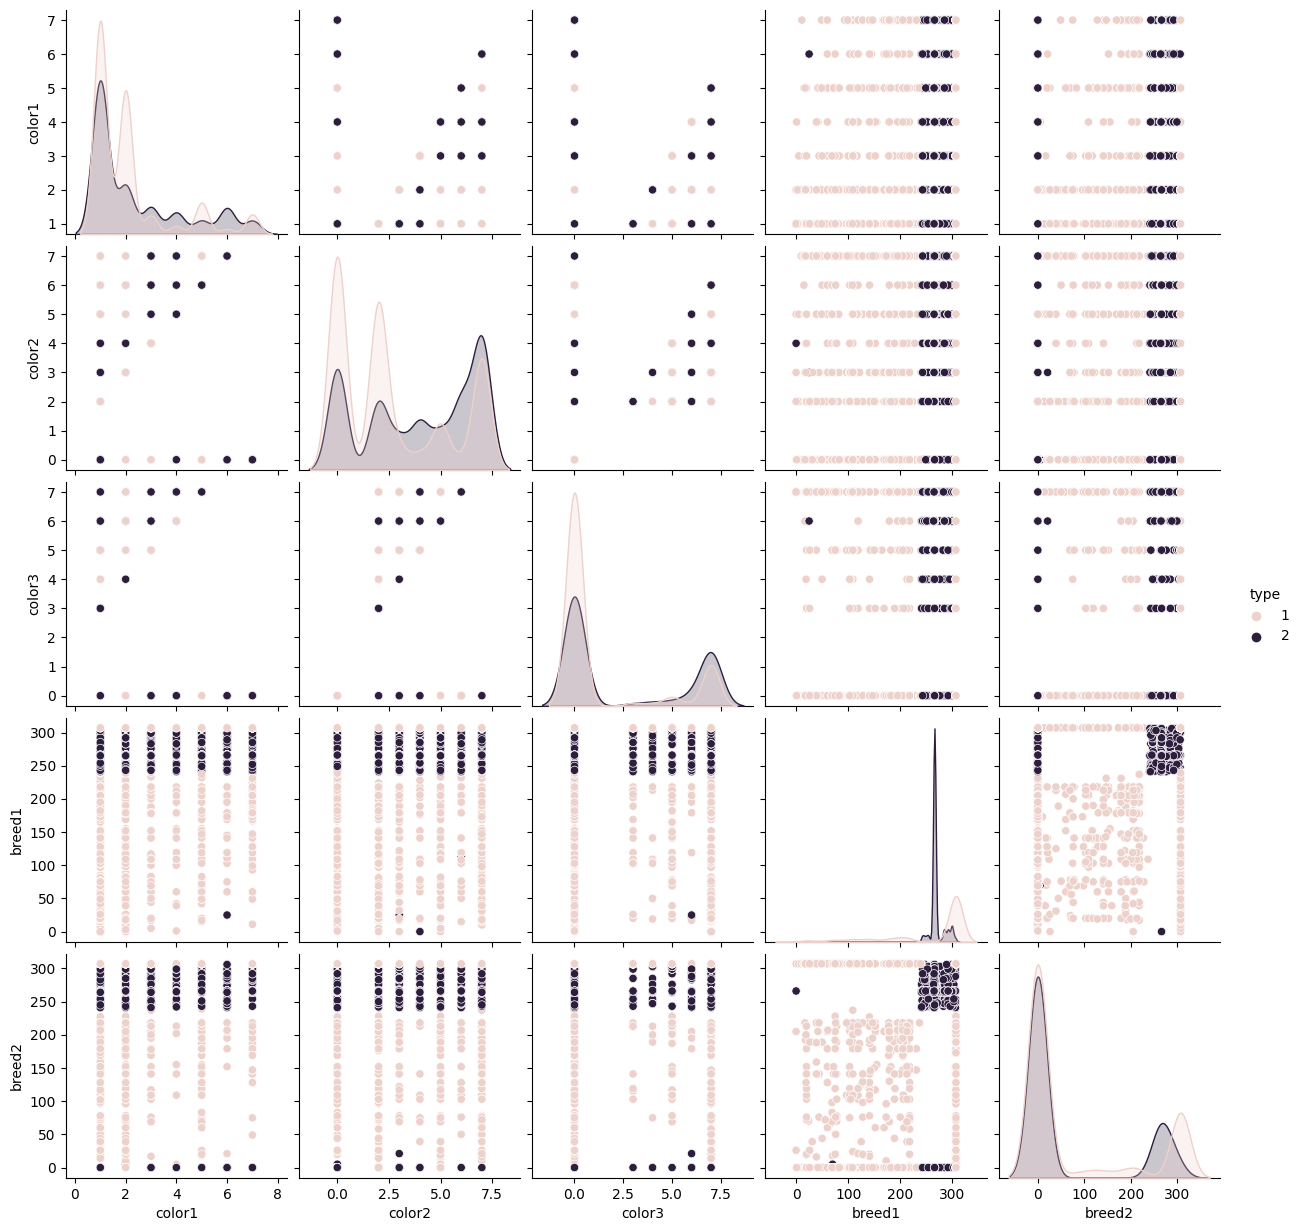

In [16]:
sns.pairplot(df_color_breed, hue="type")

color feature is filled in in numerical order: color1 < color2 < color3 (except for 0), not sorted by primary color
dark: (color1,color2,color3)= (1,0,0), (2,0,0), (6,0,0), (1,2,0), (1,6,0), (1,2,6), (2,6,0)
mixed: else
light: (3,0,0), (4,0,0), (5,0,0), (7,0,0), (3,4,0), (3,5,0), (3,7,0), (3,4,5), (3,4,7), (3,5,7), (4,5,0), (4,5,7), (4,7,0), (5,7,0)

1,"Black"
2,"Brown"
3,"Golden"
4,"Yellow"
5,"Cream"
6,"Gray"
7,"White"

breed: mixed breed/no breed 2 dominant, supporting the idea of mixed vs. pure breed feature (stumpy tail breed not in data set)
cat mixed breed: domestic short hair, domestic medium hair, domestic long hair are considered mixed breeds, breed1=!breed2
dog mixed breed: category 307 or different entries in breed1 and breed2 column. Pure breed: entry =!307 in breed 1 and breed2=0


In [17]:
patternlist = []
for colorcode in (df_dropped.color1.astype(str) + df_dropped.color2.astype(str) + df_dropped.color3.astype(str)):
    if colorcode in ("100","200","600","120","160","126","260"):
        patternlist.append(0) # 0 = dark color pattern
    elif colorcode in ("300", "400", "500", "700", "340", "350", "370", "345", "347", "357", "450", "457", "470", "570"):
        patternlist.append(1) # 1 = light color pattern
    else:
        patternlist.append(2) # 2 = mixed color pattern

df_dropped["color_pattern"] = patternlist

In [18]:
df_dropped[["color_pattern"]].value_counts()

color_pattern
2                7533
0                4598
1                2862
Name: count, dtype: int64

In [19]:
df_dropped.head()

,type,age,breed1,breed2,gender,color1,color2,color3,maturitysize,furlength,...,dewormed,sterilized,health,quantity,fee,videoamt,description,photoamt,adoptionspeed,color_pattern
0,2,3,299,0,1,1,7,0,1,1,...,2,2,1,1,100,0,Nibble is a 3+ month old ball of cuteness. He ...,1.0,2,2
1,2,1,265,0,1,1,2,0,2,2,...,3,3,1,1,0,0,I just found it alone yesterday near my apartm...,2.0,0,0
2,1,1,307,0,1,2,7,0,2,2,...,1,2,1,1,0,0,Their pregnant mother was dumped by her irresp...,7.0,3,2
3,1,4,307,0,2,1,2,0,2,1,...,1,2,1,1,150,0,"Good guard dog, very alert, active, obedience ...",8.0,2,0
4,1,1,307,0,1,1,0,0,2,1,...,2,2,1,1,0,0,This handsome yet cute boy is up for adoption....,3.0,2,0


In [20]:
df_dropped.breed2.value_counts()

breed2
0      10762
307     1727
266      599
265      321
299      138
       ...  
104        1
36         1
17         1
257        1
279        1
Name: count, Length: 135, dtype: int64

In [21]:

# breed: mixed breed/no breed 2 dominant, supporting the idea of mixed vs. pure breed feature (stumpy tail breed not in data set)
# cat mixed breed: domestic short hair, domestic medium hair, domestic long hair are considered mixed breeds, breed1=!breed2
# dog mixed breed: category 307 or different entries in breed1 and breed2 column. Pure breed: entry =!307 in breed 1 and breed2=0

#264,2,"Domestic Long Hair"
#265,2,"Domestic Medium Hair"
#266,2,"Domestic Short Hair"

#pure_bred: breed2=0 & breed1 != 307, 264, 265, 266



In [22]:
df_dropped.query('breed1 == breed2 and breed1 != 307 and breed1 != 264 and breed1 != 265 and breed1 != 266').breed1.value_counts()

breed1
179    10
292     9
299     8
243     8
205     8
254     7
109     6
285     6
218     6
283     6
141     4
195     4
247     4
69      4
103     4
306     3
155     3
213     3
189     3
241     3
20      3
119     2
76      2
242     1
60      1
300     1
65      1
26      1
305     1
206     1
295     1
187     1
78      1
25      1
21      1
150     1
122     1
72      1
270     1
152     1
19      1
267     1
303     1
Name: count, dtype: int64

In [23]:
breedlist = []
df_dropped['breed_type'] = np.where((((df_dropped["breed2"] == 0) | (df_dropped["breed1"] == df_dropped["breed2"])) & (df_dropped.breed1 != 307) & (df_dropped.breed1 != 264) & (df_dropped.breed1 != 265) & (df_dropped.breed1 != 266)), 0, 1)
#if ((df_dropped.breed2 == 0 or df_dropped.breed1 == df_dropped.breed2) and df_dropped.breed1 != 307 and df_dropped.breed1 != 264 and df_dropped.breed1 != 265 and df_dropped.breed1 != 266):
 #   breedlist.append(0) #0 is for pure breed
#else:
  #  breedlist.append(1) #1 is for mixed breed
    
#print(breedlist)

In [24]:
df_dropped.breed_type.value_counts()

breed_type
1    12850
0     2143
Name: count, dtype: int64

<Axes: xlabel='adoptionspeed', ylabel='Percent'>

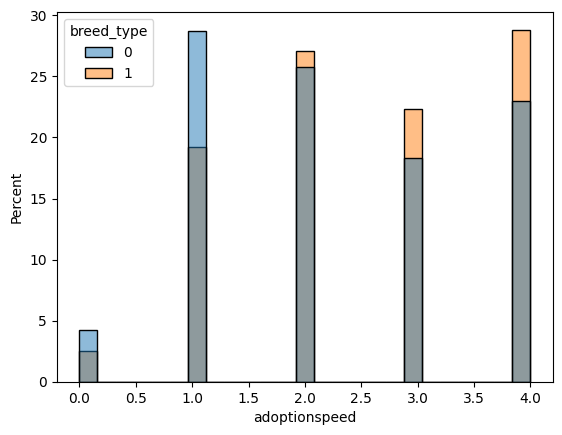

In [25]:
sns.histplot(df_dropped, x='adoptionspeed', hue= 'breed_type', stat='percent', common_norm=False)

<Axes: xlabel='adoptionspeed'>

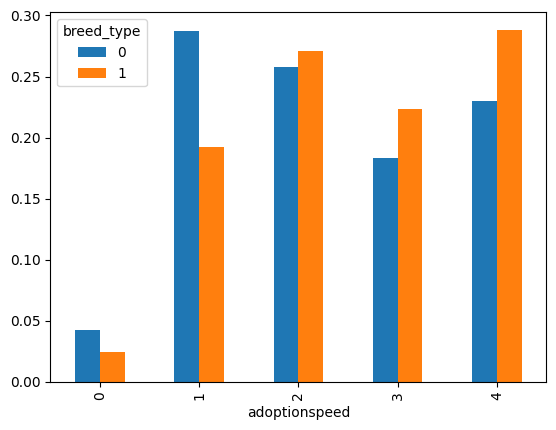

In [26]:
#we can use this graph in the presentation but separately for cats and dogs 

pd.crosstab(df_dropped["adoptionspeed"],df_dropped["breed_type"],normalize="columns").plot.bar()

In [27]:
pd.crosstab([df_dropped.type, df_dropped.breed_type], df_dropped.adoptionspeed) #normalize='index')

adoptionspeed      0     1     2     3     4
type breed_type                             
1    0            54   371   325   239   180
     1           116  1064  1839  1710  2234
2    0            37   244   227   153   313
     1           203  1411  1646  1157  1470

In [28]:
#3 means not known and we replaced it with 2 that is not vaccinated or dewormed
df_dropped['vaccinated'] = df_dropped['vaccinated'].replace(3,2)
df_dropped['dewormed'] = df_dropped['dewormed'].replace(3,2)

In [29]:
# combine the vaccinated and dewormed pets and turn it into another feature
# three categories: fully vaccinated and dewormed (0), either only vaccinated or dewormed (1), and neither vaccinated or dewormed (2) 

# create a list of our conditions
conditions = [
    ((df_dropped['vaccinated'] == 1) & (df_dropped['dewormed'] == 1)),
    ((df_dropped['vaccinated'] == 1) & (df_dropped['dewormed'] == 2)),
    ((df_dropped['vaccinated'] == 2) & (df_dropped['dewormed'] == 1)),
    ((df_dropped['vaccinated'] == 2) & (df_dropped['dewormed'] == 2))
    ]

# create a list of the values we want to assign for each condition
values = [0, 1, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
df_dropped['vaccinated_dewormed'] = np.select(conditions, values)

In [30]:
df_dropped['vaccinated_dewormed'].value_counts()

vaccinated_dewormed
2    6332
0    5634
1    3027
Name: count, dtype: int64

This new feature vaccinated_dewormed shows that adoption speed is not drastically effected by it that much, but this needs to be further investigated. But this is an important feature for further analysis as they both were highly correlated too. 

<Axes: xlabel='adoptionspeed'>

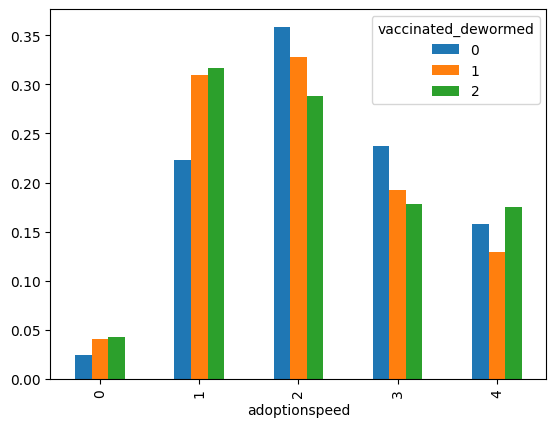

In [31]:
pd.crosstab(df_dropped.query('age < 4 & type == 2')['adoptionspeed'],df_dropped.query('age < 4 & type == 2')["vaccinated_dewormed"],normalize="columns").plot.bar()

# Age


In [38]:
# due to a very low number of instances in adoption speed 0, we will combine cat. 0 and 1
df_dropped.adoptionspeed = df_dropped.adoptionspeed.replace(0,1)

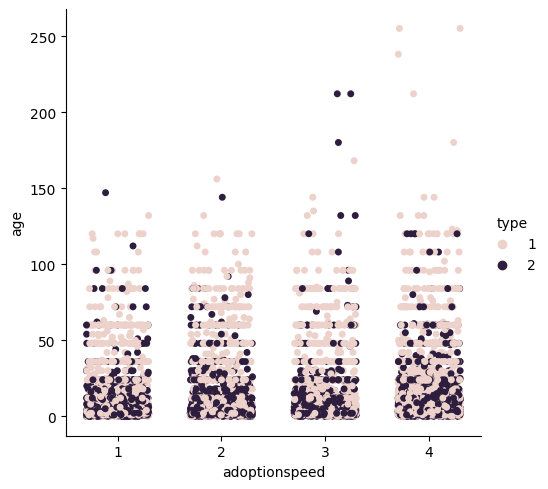

In [40]:
sns.catplot(data=df_dropped, x='adoptionspeed', y='age', hue='type', jitter=0.3)

hypothesis: cats will be adopted faster, regardless of their age, but old dogs will remain in the shelter longer. 
- younger animals are adopted faster
- there are more dogs then cats among the older animals in the shelter (adult or old dogs are in the shelter more frequently then adult or old cats)

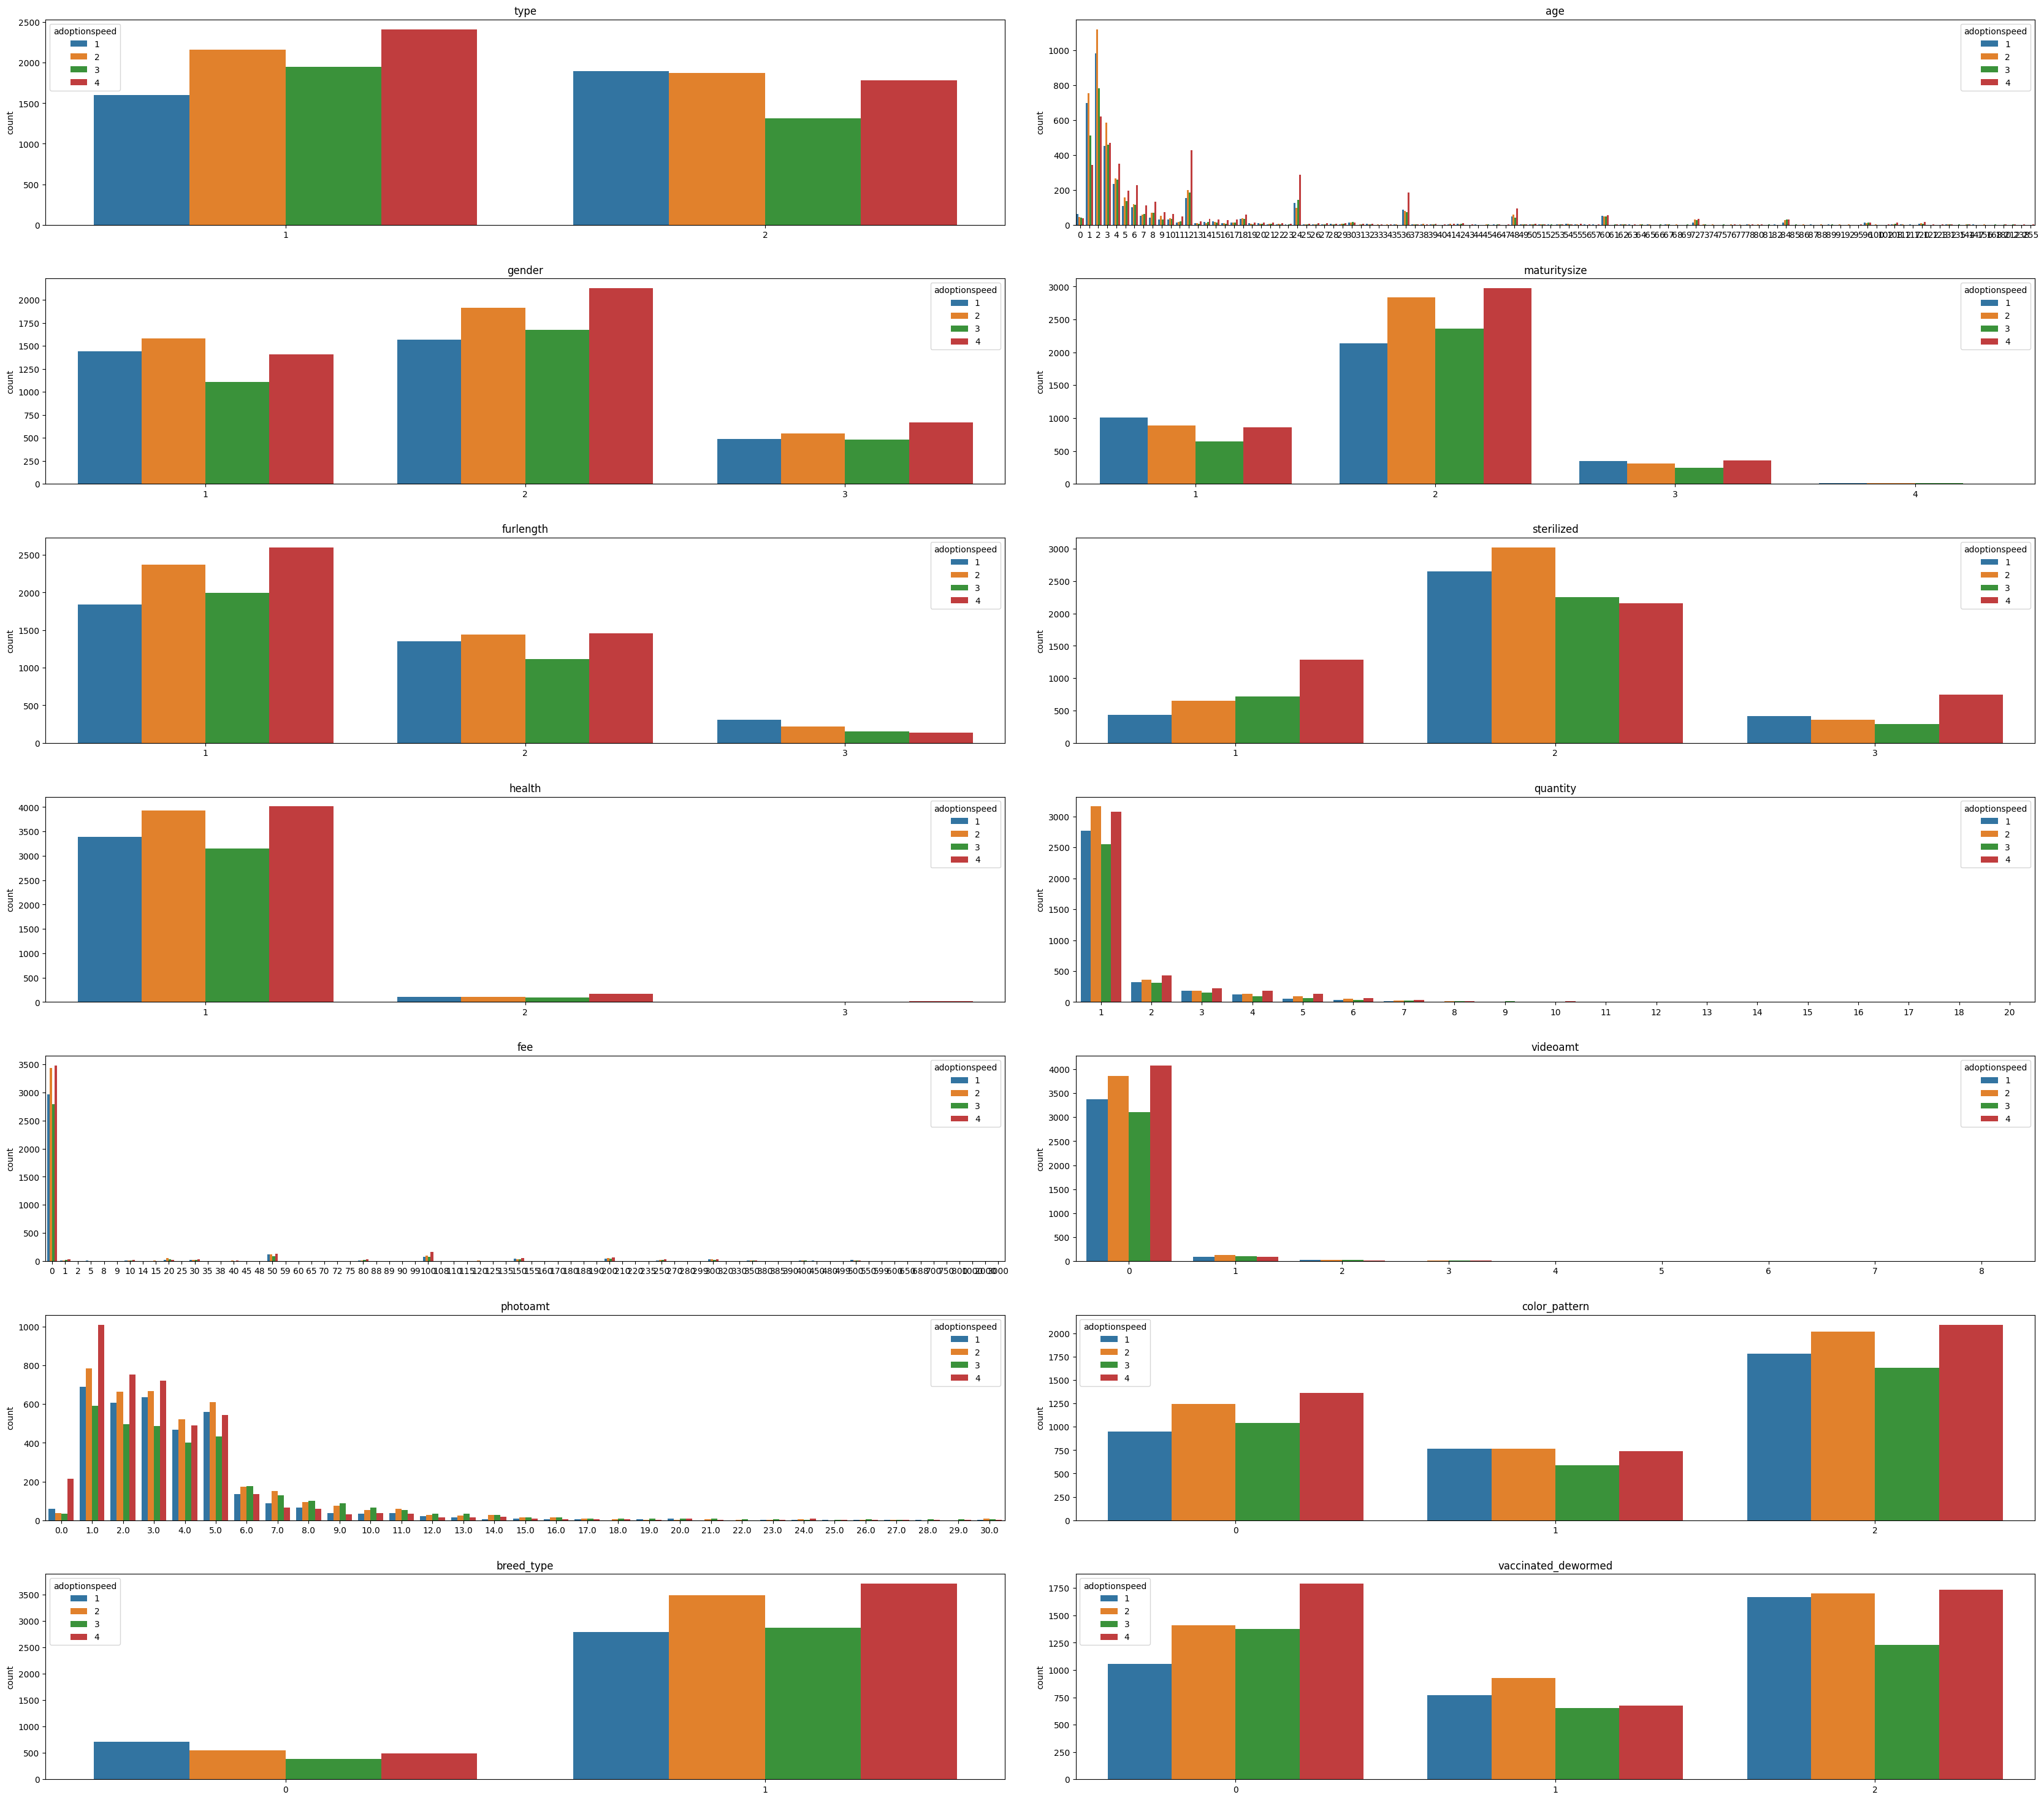

In [48]:
# Plot distribution of features 
features = ['type', 'age', 'gender', 'maturitysize', 'furlength', 'sterilized', 'health', 'quantity', 'fee', 'videoamt', 'photoamt', 'color_pattern', 'breed_type', 'vaccinated_dewormed']

fig,ax = plt.subplots(7,2,figsize=(34,30))
count = 0
for item in features:
    sns.countplot(df_dropped, x=item, ax=ax[int(count/2)][count%2], hue='adoptionspeed').set(title=item, xlabel='')#color='#33658A', kde=True
    count += 1
#ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

#fig.savefig('images/feature_histogram.jpg')

In [37]:
df_dropped.groupby('type').describe().T

type                                 1            2
age                 count  8132.000000  6861.000000
                    mean     12.906173     7.543361
                    std      21.377588    12.771554
                    min       0.000000     0.000000
                    25%       2.000000     2.000000
                    50%       3.000000     3.000000
                    75%      12.000000     8.000000
                    max     255.000000   212.000000
breed1              count  8132.000000  6861.000000
                    mean    262.088416   269.046640
                    std      80.360298    14.209506
                    min       0.000000     0.000000
                    25%     218.000000   265.000000
                    50%     307.000000   266.000000
                    75%     307.000000   266.000000
                    max     307.000000   307.000000
breed2              count  8132.000000  6861.000000
                    mean     78.932366    68.175193
                    std     126.944365   117.924234
                    min       0.000000     0.000000
                    25%       0.000000     0.000000
                    50%       0.000000     0.000000
                    75%     179.000000   241.000000
                    max     307.000000   306.000000
gender              count  8132.000000  6861.000000
                    mean      1.738072     1.821309
                    std       0.639196     0.726119
                    min       1.000000     1.000000
                    25%       1.000000     1.000000
                    50%       2.000000     2.000000
                    75%       2.000000     2.000000
                    max       3.000000     3.000000
color1              count  8132.000000  6861.000000
                    mean      2.077595     2.419764
                    std       1.593556     1.892870
                    min       1.000000     1.000000
                    25%       1.000000     1.000000
                    50%       2.000000     1.000000
                    75%       2.000000     3.000000
                    max       7.000000     7.000000
color2              count  8132.000000  6861.000000
                    mean      2.602312     3.958315
                    std       2.639396     2.680185
                    min       0.000000     0.000000
                    25%       0.000000     2.000000
                    50%       2.000000     4.000000
                    75%       5.000000     7.000000
                    max       7.000000     7.000000
color3              count  8132.000000  6861.000000
                    mean      1.329193     2.537239
                    std       2.633188     3.232753
                    min       0.000000     0.000000
                    25%       0.000000     0.000000
                    50%       0.000000     0.000000
                    75%       0.000000     7.000000
                    max       7.000000     7.000000
maturitysize        count  8132.000000  6861.000000
                    mean      1.948475     1.759510
                    std       0.502045     0.581442
                    min       1.000000     1.000000
                    25%       2.000000     1.000000
                    50%       2.000000     2.000000
                    75%       2.000000     2.000000
                    max       4.000000     4.000000
furlength           count  8132.000000  6861.000000
                    mean      1.465814     1.469465
                    std       0.585091     0.615264
                    min       1.000000     1.000000
                    25%       1.000000     1.000000
                    50%       1.000000     1.000000
                    75%       2.000000     2.000000
                    max       3.000000     3.000000
vaccinated          count  8132.000000  6861.000000
                    mean      1.519675     1.709663
                    std       0.499643     0.453951
                    min       1.000000     1.000